# K-Nearest Neighbours - solution on Iris dataset

In [1]:
%pylab inline
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

import numpy as np
import pandas as pd

iris = datasets.load_iris()

Populating the interactive namespace from numpy and matplotlib


## Scikit-Learn Implementation
The code below presents the solution with a single line of code, as per **Scikit-Learn** [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).
Note that the default settings uses _Minkowski distance_:
$$d(\vec{x}, \vec{y}) = \sum_i\left(\left|x_i - y_i\right|^p\right)^{1/p}$$
with $p = 2$, and the $K$ value was set to 3 as an aribitrary choice.

Number of mislabeled points out of a total 150 points : 6


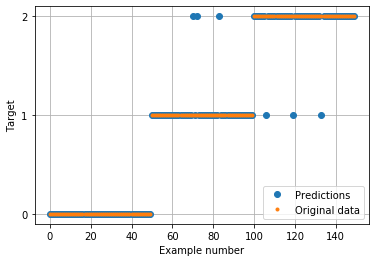

In [2]:
neigh = KNeighborsClassifier(n_neighbors=3)
y_pred = neigh.fit(iris.data, iris.target).predict(iris.data) 
print("Number of mislabeled points out of a total %d points : %d"
      % (iris.data.shape[0],(iris.target != y_pred).sum()))

fig, ax = plt.subplots()
ax.plot(y_pred, 'o')
ax.plot(iris.target, '.')
ax.set_ylabel('Target')
ax.set_xlabel('Example number')
ax.set_yticks([0, 1, 2])
ax.legend(['Predictions', 'Original data'], loc='lower right')
ax.grid()
plt.show()

Comparing the predictions with the actual labels, we can easily spot the misclassified examples (six in total).

## Dataset Analysis
Let's take a look first on selected _projections_ of the dataset on plains defined by $x_i:x_j$ feature pairs.

In [3]:
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['target'] = iris.target
df['label'] = df['target'].apply(lambda x: iris['target_names'][x])
df.sample(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,label
31,5.4,3.4,1.5,0.4,0,setosa
96,5.7,2.9,4.2,1.3,1,versicolor
119,6.0,2.2,5.0,1.5,2,virginica


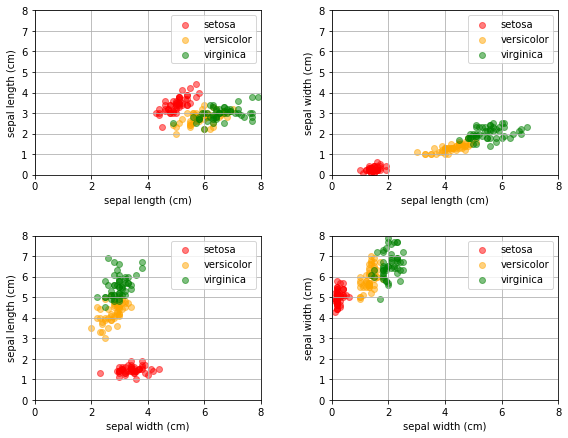

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
plt.tight_layout(h_pad=4, w_pad=4)
colors = ['red', 'orange', 'green']

for x in range(len(iris.feature_names)):
    for y, c in zip(range(len(iris.target)), colors):
        axs[x % 2, x // 2].scatter(
            df[df['target'] == y][iris.feature_names[x % 4]],
            df[df['target'] == y][iris.feature_names[(x + 1)%4]], 
            color=c,
            alpha=0.5)
        axs[x % 2, x // 2].set_xlabel(iris.feature_names[x % 2])
        axs[x % 2, x // 2].set_ylabel(iris.feature_names[x // 2])
        axs[x % 2, x // 2].grid()
        axs[x % 2, x // 2].legend(iris.target_names, loc='upper right')
        axs[x % 2, x // 2].set_xlim([0.0, 8.0])
        axs[x % 2, x // 2].set_ylim([0.0, 8.0])
        
plt.show()   

It is cumbersome to plot 4-dimensional space. However, from these 2D projections, we can see that the data highly clustered. Therefore, the classification using of the distance in this case has such a high rate of success.
Before continuing, let's split the original dataset onto training and test set.

**Note:** Here we will take a half of the dataset to be our test set.
Normally, it is recommended to take only a small fraction of the original dataset in order to be in possession of more data for training of the actual classifier.
Here, however, we would like to illustrate the impact of choosing of different $K$ parameters, thus it is actually encourage that our training set is smaller and comparable with the test set.

In [5]:
x_train, x_test, y_train, y_test = \
    train_test_split(iris.data, iris.target, test_size=0.5, random_state=0)
print ("Training set #examples: {}.".format(x_train.shape[0]))
print ("Test set     #examples: {}.".format(x_test.shape[0]))

Training set #examples: 75.
Test set     #examples: 75.


## Manual implementation
In order to build the KNN classifier, all we need is to have an ability to calculate the _distance_ between our example data point and _all_ of our training set examples AND the definition of the distance itself.
Since the solution requires sorting and keeping the index reference, we will use _pandas_ dataframe object, to be more verbose.

Here we will use the same Minkowski distance with $p=2$. This will keep our definition "open", but let us treat it as an Euclidean distance.

In [6]:
def distance(x0, x1, p=2):
    return np.power((abs(x0 - x1)**p).sum(axis=1), (1/p))

def my_knn(x_example, K=3, p=2):
    x_example = np.tile(x_example, (x_train.shape[0], 1))
    Z = pd.DataFrame(x_train)
    Z['distance'] = distance(x_example, x_train, p=p)
    Z['target'] = y_train
    Z = Z.sort_values('distance')
    chosen = Z.head(K)
    return chosen['target'].mode().values[0], chosen

Lines 1. and 2. implement the Minkowski distance, whose formula we wrote at the begining of this notebook.

In order to vectorize the calulations (always a good practice), we repeat the input example feature vector $N$ times, where $N$ is the number of training set examples.
We formulate a dataframe object.
We append one column: `distance` to the frame, which is our element-wise evaluation of the distance.
We also append the `y_train` data for easier comparison later.
Then, it's sorting and picking the top $K$ rows from the new frame.
Finally, we return the _mode_ of the solution.
In case of a _regression_ problem, we would have gone for the mean.

The function also return the selected `chosen` dataframe, but it does so only for demonstration and debugging.

### Evaluation
To evaluate our `my_knn` function we define another dataframe over or test data.
Note that evaluating the KNN classifier over training data would lead to a trivial case in which the distance would be zero, and thus our classifier would never be wrong.

In [7]:
neigh = KNeighborsClassifier(n_neighbors=3)
y_pred = neigh.fit(x_train, y_train).predict(x_test) 

Z_test = pd.DataFrame(x_test)
Z_test['original target'] = y_test
Z_test['prediction with my_knn'] = Z_test.apply(lambda x: my_knn(x[[0, 1, 2, 3]], K=3)[0], axis=1)
Z_test['prediction with sklearn'] = y_pred
Z_test.head()

,0,1,2,3,original target,prediction with my_knn,prediction with sklearn
0,5.8,2.8,5.1,2.4,2,2,2
1,6.0,2.2,4.0,1.0,1,1,1
2,5.5,4.2,1.4,0.2,0,0,0
3,7.3,2.9,6.3,1.8,2,2,2
4,5.0,3.4,1.5,0.2,0,0,0


As a side note, we evaluate `my_knn` function using `.apply` method involving anonymous function.
Therefore, `x[[0, 1, 2, 3]]` and `axis=1` are used to refer to the first four columns of each row in the dataframe,
and the `[0]` appended to our function call comes from the `my_knn` definition where two outputs are returned.

In [8]:
assert (Z_test['prediction with my_knn'].to_numpy() == Z_test['prediction with sklearn'].to_numpy()).sum() == len(Z_test)

It seems our implementation gives identical results to the one offered with scikit-learn. This is comforting.

As a final step, let's take a look at what different values of $K$ do to the data.

## Playing with K

In [9]:
Kmax = 30
Z_test = pd.DataFrame(x_test)
Z_test['original target'] = y_test
for k in range(Kmax):
    Z_test['pred K={}'.format(k + 1)] = Z_test.apply(lambda x: my_knn(x[[0, 1, 2, 3]], K=(k + 1))[0], axis=1)
    
Z_test.head()

,0,1,2,3,original target,pred K=1,pred K=2,pred K=3,pred K=4,pred K=5,...,pred K=21,pred K=22,pred K=23,pred K=24,pred K=25,pred K=26,pred K=27,pred K=28,pred K=29,pred K=30
0,5.8,2.8,5.1,2.4,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
1,6.0,2.2,4.0,1.0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,5.5,4.2,1.4,0.2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,7.3,2.9,6.3,1.8,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
4,5.0,3.4,1.5,0.2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
correctly_classfied = np.zeros(Kmax)

count = y_test.shape[0]
for k in range(Kmax):
    correctly_classfied[k] = (Z_test['original target'] == Z_test['pred K={}'.format(k + 1)]).sum()/count

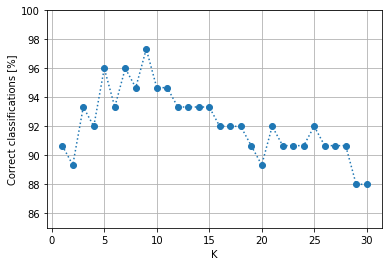

In [11]:
plt.plot(np.linspace(1, stop=30, num=30), 100*correctly_classfied, ':o')
plt.xlabel('K')
plt.ylabel('Correct classifications [%]')
plt.ylim([85, 100])
plt.grid()
plt.show()

The figure above shows the behavior of the KNN classifier for different values of $K$.
We can see that the optimal value in this case is $K=9$.

It is interesting to observe that lower values of $K$ do not perform optimally, as there is not enough number of "voters" to make the average (or mode) be strong enough to make a good decision.
Conversly, having too many nerighbours stretches the geometrical region that contributes to making the decision, which is also not good.

Finally, it is worth to mention that **odd** $K$'s perform better than **even** values.
The reason behind it is the fact that with odd number of neighbours there is never a "draw" in making of the decision.
When the number is even, it can happen that two values of equal distances are found, in which case the classifier would choose the the one that is sorted first to be the winner.
Consequently, this approach does not guarantee that the selected output is the correct one, making the decision somewhat random.

## Conclusion
In this notebook we have demonsrated the principle behind K-Nearest Neighbours algorithm for classification.

The importan take-aways from this example:
* K-NN works requiers the entire dataset to construct the model.
* It is important to agree on the distance metrics. Common choice is the Euclidean distance (Minkowski with p=2).
* For classification problems we select the _mode_.
* For regression problem we select the _mean_.
* The value of $K$ should neither be too large nor too small.
* Odd number of $K$ is recommended.